# Technological Infrastructures for Data Science
## Spark Challenge - Andrea Seveso (781856)
Let's start by importing libraries and dataset.
Then we will check the schema

In [1]:
# Import libs
%matplotlib inline
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf
from pyspark.sql.types import *
import matplotlib.pyplot as plt

# Create Spark context
sc = SparkContext.getOrCreate()
sqlContext = SQLContext(sc)

# Load data frame
df = sqlContext.read.format('com.databricks.spark.csv').\
options(header='true', inferschema='true', sep = ";").load('../data/risultati_totali.csv')

# Print df schema
df.printSchema()

root
 |-- F1: integer (nullable = true)
 |-- F2: integer (nullable = true)
 |-- F3: integer (nullable = true)
 |-- F4: string (nullable = true)
 |-- Rep: integer (nullable = true)
 |-- M_OF: integer (nullable = true)
 |-- M_TIME(s): string (nullable = true)
 |-- CBC_OF: integer (nullable = true)
 |-- CBC_TIME: string (nullable = true)
 |-- CBC_#FEASIBILITY CUTS: integer (nullable = true)
 |-- CBC_# PENALTY CUTS: integer (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)



## Cleaning the schema
There are some problems with the data frame:
1. Some columns have special characters: #, (). Let's remove these.
2. The columns M_TIME and CBC_TIME are cast as string, but they should be as double. Also, the decimal delimiter is comma instead of dot.
3. There are some useless empty columns in the end (all NAs). They should be removed aswell.

In [2]:
# User defined function to replace commas and cast as float
commaToDot = udf(lambda x : float(str(x).replace(',', '.')), FloatType())

# Rename columns with special characters
df = df.withColumnRenamed("M_TIME(s)", "M_TIME").\
    withColumnRenamed("CBC_# PENALTY CUTS", "CBC_PENALTY_CUTS").\
    withColumnRenamed("CBC_#FEASIBILITY CUTS", "CBC_FEASIBILITY_CUTS")

# Cast as float columns and keep only useful columns
df = df.withColumn('CBC_TIME', commaToDot(df.CBC_TIME)).\
    withColumn('M_TIME', commaToDot(df.M_TIME)).\
    select("F1", "F2", "F3", "F4", "Rep", "M_OF", "M_TIME", "CBC_OF", "CBC_TIME", "CBC_FEASIBILITY_CUTS", "CBC_PENALTY_CUTS")

# Cache the df
df.cache()

# Check if everything is ok now
df.printSchema()
df.show(5)

root
 |-- F1: integer (nullable = true)
 |-- F2: integer (nullable = true)
 |-- F3: integer (nullable = true)
 |-- F4: string (nullable = true)
 |-- Rep: integer (nullable = true)
 |-- M_OF: integer (nullable = true)
 |-- M_TIME: float (nullable = true)
 |-- CBC_OF: integer (nullable = true)
 |-- CBC_TIME: float (nullable = true)
 |-- CBC_FEASIBILITY_CUTS: integer (nullable = true)
 |-- CBC_PENALTY_CUTS: integer (nullable = true)

+---+---+---+---+---+----+------+------+--------+--------------------+----------------+
| F1| F2| F3| F4|Rep|M_OF|M_TIME|CBC_OF|CBC_TIME|CBC_FEASIBILITY_CUTS|CBC_PENALTY_CUTS|
+---+---+---+---+---+----+------+------+--------+--------------------+----------------+
|  3|400|  9|  A|  1| 361| 0.266|   361|   0.462|                   0|               0|
|  3|400|  9|  A|  2| 306| 0.511|   306|   0.106|                   0|               0|
|  3|400|  9|  A|  3| 271| 1.052|   271|   1.646|                   0|               4|
|  3|400|  6|  A|  4| 263| 0.556|   2

# Descriptive statistics
Let's check some descriptive statistics about the features and algorithm results.

In [37]:
# Descriptive stats for features
df.describe('F1','F2','F3', 'F4').show()

+-------+------------------+-----------------+------------------+----+
|summary|                F1|               F2|                F3|  F4|
+-------+------------------+-----------------+------------------+----+
|  count|               360|              360|               360| 360|
|   mean|               6.0|            500.0| 9.155555555555555|null|
| stddev|2.9480176050089826|81.76329719869562|1.6295400592512068|null|
|    min|                 3|              400|                 6|   A|
|    max|                10|              600|                14|   D|
+-------+------------------+-----------------+------------------+----+



In [38]:
# Descriptive stats for algorithm results
df.describe('M_OF','M_TIME','CBC_OF', 'CBC_TIME', 'CBC_FEASIBILITY_CUTS', 'CBC_PENALTY_CUTS').show()

+-------+----------------+------------------+------------------+------------------+--------------------+-----------------+
|summary|            M_OF|            M_TIME|            CBC_OF|          CBC_TIME|CBC_FEASIBILITY_CUTS| CBC_PENALTY_CUTS|
+-------+----------------+------------------+------------------+------------------+--------------------+-----------------+
|  count|             360|               360|               360|               360|                 360|              360|
|   mean|         271.575|105.12110819009443|270.85833333333335| 87.07493861282968|0.019444444444444445|4.852777777777778|
| stddev|98.3542284190714|494.45800971272115| 98.25782943139056|382.65763169719463| 0.15713210460545812| 10.1040819162897|
|    min|              82|              0.08|                82|              0.01|                   0|                0|
|    max|             658|            3600.0|               658|            3600.0|                   2|               73|
+-------+-------

# Visualizing the dataset
Since the dataset is small enough, we can convert it to a pandas dataframe to visualize it.  
If it were too large, we could have used the function sample to extract some data.

In [ ]:
# Converting to Pandas for visualization with Matplotlib
dfPanda = df.toPandas()

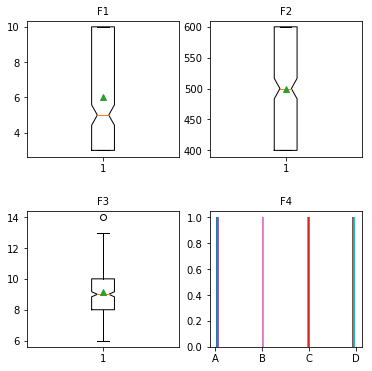

In [37]:
fs = 10 
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6))

axes[0, 0].boxplot(dfPanda['F1'], showmeans=True, notch=True)
axes[0, 0].set_title('F1', fontsize=fs)

axes[0, 1].boxplot(dfPanda['F2'], showmeans=True, notch=True)
axes[0, 1].set_title('F2', fontsize=fs)

axes[1, 0].boxplot(dfPanda['F3'], showmeans=True, notch=True)
axes[1, 0].set_title('F3', fontsize=fs)

axes[1, 1].hist(dfPanda['F4'])
axes[1, 1].set_title('F4', fontsize=fs)

fig.subplots_adjust(hspace=0.4)
plt.show()

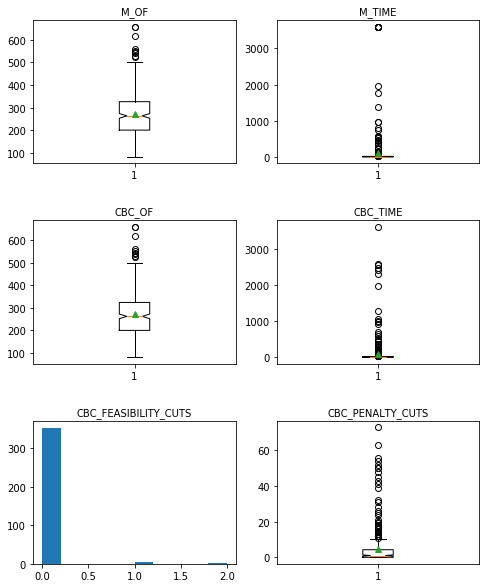

In [45]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))

axes[0, 0].boxplot(dfPanda['M_OF'], showmeans=True, notch=True)
axes[0, 0].set_title('M_OF', fontsize=fs)

axes[0, 1].boxplot(dfPanda['M_TIME'], showmeans=True, notch=True)
axes[0, 1].set_title('M_TIME', fontsize=fs)

axes[1, 0].boxplot(dfPanda['CBC_OF'], showmeans=True, notch=True)
axes[1, 0].set_title('CBC_OF', fontsize=fs)

axes[1, 1].boxplot(dfPanda['CBC_TIME'], showmeans=True, notch=True)
axes[1, 1].set_title('CBC_TIME', fontsize=fs)

axes[2, 0].hist(dfPanda['CBC_FEASIBILITY_CUTS'])
axes[2, 0].set_title('CBC_FEASIBILITY_CUTS', fontsize=fs)

axes[2, 1].boxplot(dfPanda['CBC_PENALTY_CUTS'], showmeans=True, notch=True)
axes[2, 1].set_title('CBC_PENALTY_CUTS', fontsize=fs)

fig.subplots_adjust(hspace=0.4)
plt.show()

# What's with the outliers?!  
The time of execution of algorithms for some element seems way off.  
We could see it at the descriptive statistics:  
E.g. for CBC_TIME mean is 87.07, std is 382.6 (ouch) and max is 3600... 9 standard deviations away from the mean!  
We have to investigate on what is the root cause of this.

In [46]:
(3600 - 87) / 382

9.196335078534032